# IT Support Dashboard - Supporting Notebook

This notebook contains supporting documentation to the full report. Here, we provide quality checks for the full dataset, confirm whether the English-only sample is representitive of the full population available, and conduct text analytics.

In [1]:
# Importing essential packages
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# Add parent directory (project root) to sys.path
project_root = Path(r"C:\Users\David\Desktop\Python_Files\IT-Support-Ticket-Analysis")
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from config import Config

Config.ensure_directories()

# Reading the initial dataset as a DataFrame: df
# pickle_path = Config.QC_CSV_DIR / "Tickets_Clean.pkl"
# df = pd.read_pickle(pickle_path)

parquet_path = Config.QC_CSV_DIR / "Tickets_Clean.parquet"
df = pd.read_parquet(parquet_path)

df  # Display the DataFrame to verify successful import

[Config] Verified project directory structure under C:\Users\David\Desktop\Python_Files\IT-Support-Ticket-Analysis


,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Wesentlicher Sicherheitsvorfall,"Sehr geehrtes Support-Team,\n\nich möchte eine...",Vielen Dank für die Meldung des kritischen Sic...,Incident,Technical Support,High,De,51,Security,Outage,Disruption,Data Breach,NaN,NaN,NaN,NaN
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,High,En,51,Account,Disruption,Outage,IT,Tech Support,NaN,NaN,NaN
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,Medium,En,51,Product,Feature,Tech Support,NaN,NaN,NaN,NaN,NaN
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",We appreciate you reaching out with your billi...,Request,Billing and Payments,Low,En,51,Billing,Payment,Account,Documentation,Feedback,NaN,NaN,NaN
4,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",Thank you for your inquiry. Our product suppor...,Problem,Sales and Pre-Sales,Medium,En,51,Product,Feature,Feedback,Tech Support,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28575,Performance Problem with Data Analytics Tool,The data analytics tool experiences sluggish p...,We are addressing the performance issue with t...,Incident,Technical Support,High,En,400,Performance,IT,Tech Support,NaN,NaN,NaN,NaN,NaN
28576,Datensperrung in der Kundschaftsbetreuung,"Es gab einen Datensperrungsunfall, bei dem ung...",Ich kann Ihnen bei dem Datensperrungsunfall he...,Incident,Product Support,High,De,400,Security,IT,Tech Support,Bug,NaN,NaN,NaN,NaN
28577,Problem mit der Videokonferenz-Software heute,Wichtigere Sitzungen wurden unterbrochen durch...,"Sehr geehrte/r [Name], leider wurde das Proble...",Incident,Human Resources,Low,De,400,Bug,Performance,Network,IT,Tech Support,NaN,NaN,NaN
28578,Update Request for SaaS Platform Integration F...,Requesting an update on the integration featur...,Received your request for updates on the integ...,Change,IT Support,High,En,400,Feature,IT,Tech Support,NaN,NaN,NaN,NaN,NaN


## 1) Representativeness checks

This dataset contained records with English and German responses. For text analytics, we wanted to remove the German records to keep only clusters which we could infer from. Therefore, we carried out representativeness checks to confirm if the English-only subset remained statistically representative to the full dataset and avoided sampling bias. For this purpose, we measured absolute proportion shifts, Chi-square tests, and Cramér’s V strength of associations tests on these dimensions: type, priority, and queue.

In [2]:
# Create English-only subset
df["language"] = df["language"].astype(str).str.lower().str.strip()
df_en = df[df["language"] == "en"].copy()

# Saving the English-only subset to CSV
output_path = Config.REP_CSV_DIR / "English_Tickets.csv"
df_en.to_csv(output_path, index=False, encoding="utf-8")

# Calculate the percentage reduction of records from subsetting
percent_reduction = (1 - len(df_en) / len(df)) * 100

print(f"English-only rows: {len(df_en)}")
print(f"Absolute reduction: {len(df) - len(df_en)} rows")
print("Percent reduction: {:.2f}%".format(percent_reduction))

English-only rows: 16335
Absolute reduction: 12245 rows
Percent reduction: 42.84%


### Absolute Proportion Shifts

In [3]:
# Helper: produce comparison table for a categorical column
def compare_distribution(col, top_n=50):
    full_series = df[col].astype(str).str.strip()
    en_series = df_en[col].astype(str).str.strip()
    full_counts = full_series.value_counts(dropna=False)
    en_counts = en_series.value_counts(dropna=False)

    # combine categories present in either
    all_cats = sorted(
        set(full_counts.index).union(set(en_counts.index)),
        key=lambda x: (-full_counts.get(x, 0), str(x)),
    )

    rows = []

    for c in all_cats[:top_n]:
        fct = int(full_counts.get(c, 0))
        ect = int(en_counts.get(c, 0))
        f_pct = fct / full_counts.sum() if full_counts.sum() > 0 else 0
        e_pct = ect / en_counts.sum() if en_counts.sum() > 0 else 0
        abs_diff = e_pct - f_pct
        rel_diff = (abs_diff / f_pct) if f_pct != 0 else np.nan
        rows.append((c, fct, ect, f_pct, e_pct, abs_diff, rel_diff))

    result = pd.DataFrame(
        rows,
        columns=[
            col,
            "full_count",
            "en_count",
            "full_pct",
            "en_pct",
            "abs_pct_diff",
            "rel_pct_diff",
        ],
    )

    result = result.sort_values(by="full_count", ascending=False).reset_index(drop=True)
    return result


# Compute distributions and summary metrics
distributions = {}
summary = []
comparrison_cols = ["priority", "type", "queue", "version"]

# Loop through the dimensions array to produce summary tables for absolute proportional shifts
for col in comparrison_cols:
    # Error message for missed dimensions
    if col not in df.columns:
        print(f"WARNING: column '{col}' not in dataset — skipping.")
        continue

    print(f"\nDistributions table for column: '{col}':")

    dist = compare_distribution(col, top_n=200)
    distributions[col] = dist

    # L1 metric (sum absolute proportion diffs)
    L1 = dist["abs_pct_diff"].abs().sum()
    idx_max = dist["abs_pct_diff"].abs().idxmax()
    max_cat = dist.loc[idx_max, col]
    max_abs = dist.loc[idx_max, "abs_pct_diff"]

    summary.append(
        {
            "column": col,
            "L1_total_abs_pct_diff": L1,
            "max_diff_category": max_cat,
            "max_abs_pct_diff": max_abs,
        }
    )

    # show the small table
    display(
        dist.style.format(
            {
                "full_count": "{:,}",
                "en_count": "{:,}",
                "full_pct": "{:.3%}",
                "en_pct": "{:.3%}",
                "abs_pct_diff": "{:.3%}",
                "rel_pct_diff": "{:.1%}",
            }
        )
    )

    dist.to_csv(
        Config.REP_CSV_DIR / f"Distribution_Comparison_{col.capitalize()}.csv",
        index=False,
        encoding="utf-8",
    )


summary_df = pd.DataFrame(summary)
print("\nSummary of distribution shifts:")
display(
    summary_df.style.format(
        {"L1_total_abs_pct_diff": "{:.3%}", "max_abs_pct_diff": "{:.3%}"}
    )
)
summary_df.to_csv(
    Config.REP_CSV_DIR / "Distribution_Shift_Summary.csv", index=False, encoding="utf-8"
)


Distributions table for column: 'priority':


,priority,full_count,en_count,full_pct,en_pct,abs_pct_diff,rel_pct_diff
0,Medium,"11,512","6,616",40.280%,40.502%,0.222%,0.6%
1,High,"11,175","6,345",39.101%,38.843%,-0.258%,-0.7%
2,Low,"5,893","3,374",20.619%,20.655%,0.036%,0.2%



Distributions table for column: 'type':


,type,full_count,en_count,full_pct,en_pct,abs_pct_diff,rel_pct_diff
0,Incident,"11,465","6,571",40.115%,40.227%,0.111%,0.3%
1,Request,"8,185","4,665",28.639%,28.558%,-0.081%,-0.3%
2,Problem,"6,008","3,394",21.022%,20.777%,-0.244%,-1.2%
3,Change,"2,922","1,705",10.224%,10.438%,0.214%,2.1%



Distributions table for column: 'queue':


,queue,full_count,en_count,full_pct,en_pct,abs_pct_diff,rel_pct_diff
0,Technical Support,"8,361","4,736",29.255%,28.993%,-0.262%,-0.9%
1,Product Support,"5,249","3,071",18.366%,18.800%,0.434%,2.4%
2,Customer Service,"4,267","2,410",14.930%,14.754%,-0.176%,-1.2%
3,IT Support,"3,433","1,942",12.012%,11.889%,-0.123%,-1.0%
4,Billing and Payments,"2,786","1,595",9.748%,9.764%,0.016%,0.2%
5,Returns and Exchanges,"1,437",820,5.028%,5.020%,-0.008%,-0.2%
6,Service Outages and Maintenance,"1,148",664,4.017%,4.065%,0.048%,1.2%
7,Sales and Pre-Sales,918,513,3.212%,3.140%,-0.072%,-2.2%
8,Human Resources,576,348,2.015%,2.130%,0.115%,5.7%
9,General Inquiry,405,236,1.417%,1.445%,0.028%,2.0%



Distributions table for column: 'version':


,version,full_count,en_count,full_pct,en_pct,abs_pct_diff,rel_pct_diff
0,400,"18,594","10,438",65.059%,63.900%,-1.160%,-1.8%
1,52,"9,117","5,346",31.900%,32.727%,0.827%,2.6%
2,51,869,551,3.041%,3.373%,0.333%,10.9%



Summary of distribution shifts:


,column,L1_total_abs_pct_diff,max_diff_category,max_abs_pct_diff
0,priority,0.516%,High,-0.258%
1,type,0.650%,Problem,-0.244%
2,queue,1.282%,Product Support,0.434%
3,version,2.320%,400,-1.160%


Visual representation of the absolute proportion shifts

Visual for priority:


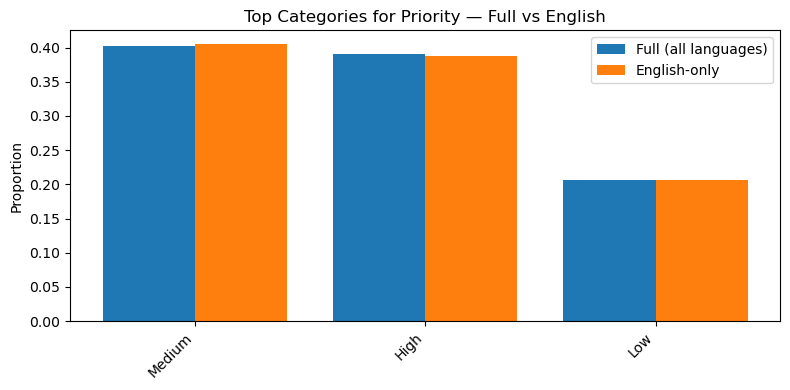

Visual for type:


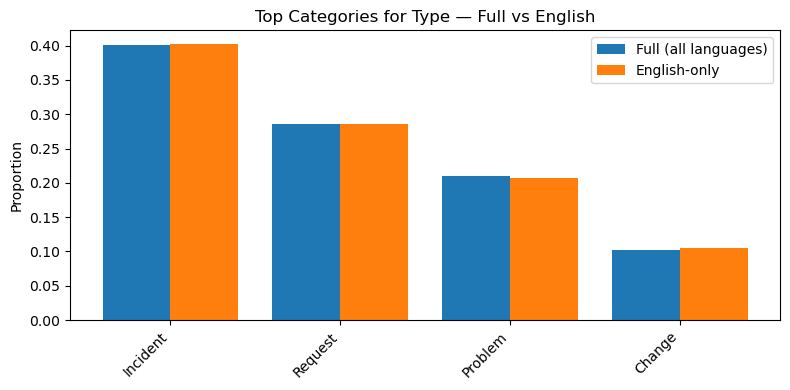

Visual for queue:


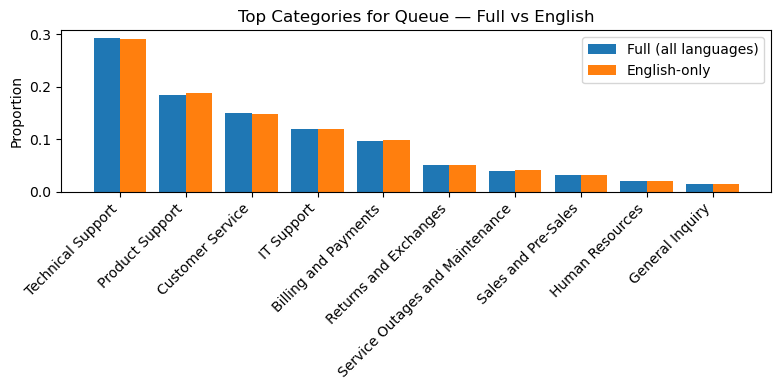

Visual for version:


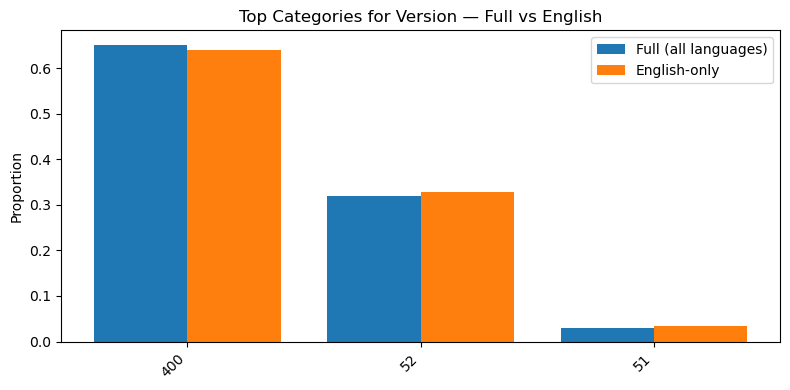

In [4]:
# Import required packages for visualization
import matplotlib.pyplot as plt

# Visual quick checks (bar charts of full vs en proportions) for each column
for col, tbl in distributions.items():
    fig, ax = plt.subplots(figsize=(8, 4))
    x = np.arange(len(tbl))

    ax.bar(x - 0.2, tbl["full_pct"], width=0.4, label="Full (all languages)")
    ax.bar(x + 0.2, tbl["en_pct"], width=0.4, label="English-only")

    ax.set_xticks(x)
    ax.set_xticklabels(tbl[col], rotation=45, ha="right")
    ax.set_ylabel("Proportion")
    ax.set_title(f"Top Categories for {col.capitalize()} — Full vs English")
    ax.legend()
    plt.tight_layout()

    image_path = Config.REP_IMG_DIR / f"Distribution_Comparison_{col.capitalize()}.png"
    plt.savefig(image_path, dpi=300, bbox_inches="tight")

    print(f"Visual for {col}:")
    plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_7216\276948917.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Visual for priority:


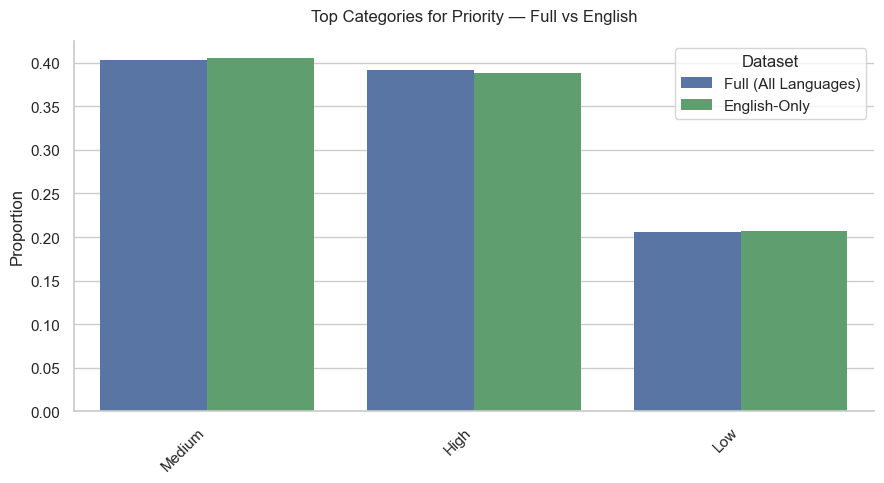

C:\Users\David\AppData\Local\Temp\ipykernel_7216\276948917.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Visual for type:


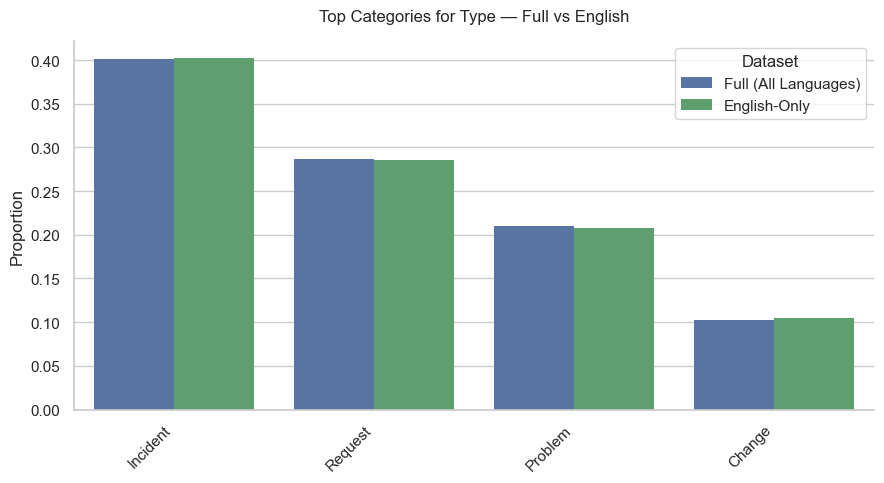

C:\Users\David\AppData\Local\Temp\ipykernel_7216\276948917.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Visual for queue:


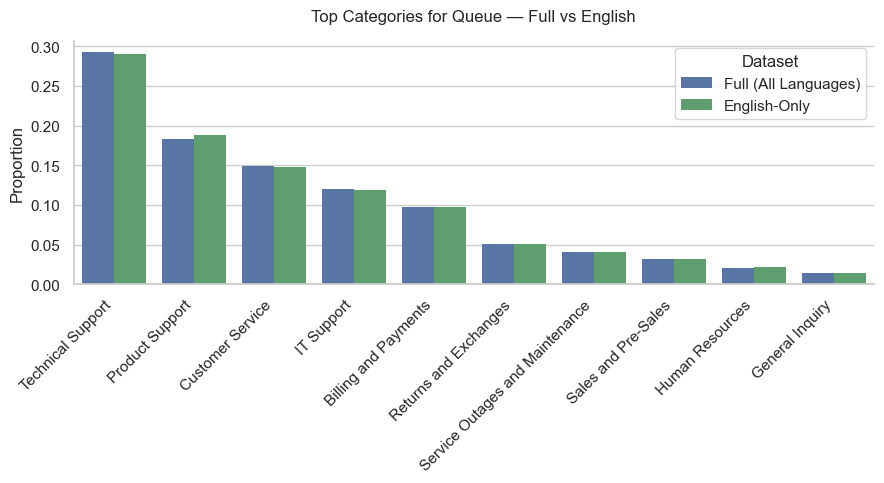

C:\Users\David\AppData\Local\Temp\ipykernel_7216\276948917.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Visual for version:


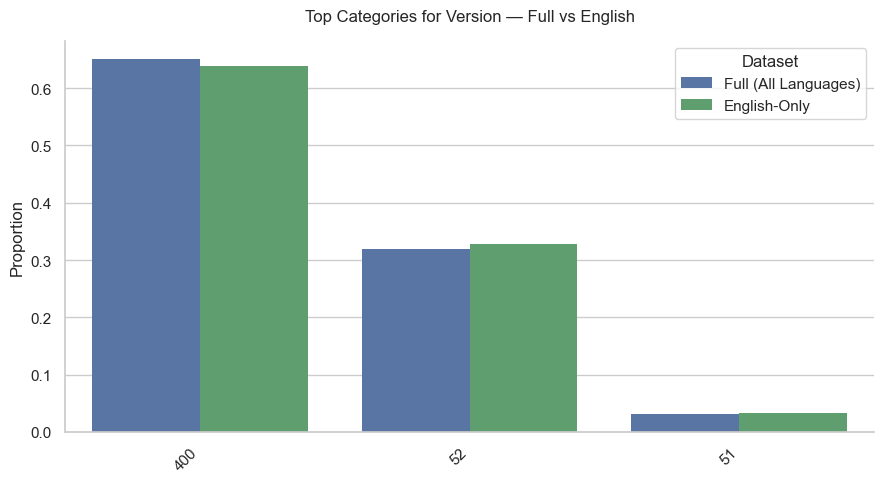

In [ ]:
# ==========================================================
# Visual quick checks
# ==========================================================
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from config import Config

# Apply Seaborn theme globally
sns.set_theme(style="whitegrid")

# Loop through columns to plot each distribution comparison
for col, tbl in distributions.items():
    # Prepare tidy data for Seaborn (long-form melt)
    df_plot = tbl.melt(
        id_vars=[col],
        value_vars=["full_pct", "en_pct"],
        var_name="Dataset",
        value_name="Proportion",
    )
    df_plot["Dataset"] = df_plot["Dataset"].replace(
        {"full_pct": "Full (All Languages)", "en_pct": "English-Only"}
    )

    # Create figure
    plt.figure(figsize=(9, 5))
    ax = sns.barplot(
        data=df_plot,
        x=col,
        y="Proportion",
        hue="Dataset",
        palette=["#4C72B0", "#55A868"],
        edgecolor="none",
    )

    methods_barchart.set(ylim=(0, 7500), yticks=np.linspace(0, 7500, 16))

    # Titles and labels
    ax.set_title(f"Top Categories for {col.capitalize()} — Full vs English", pad=14)
    ax.set_xlabel("")
    ax.set_ylabel("Proportion")

    # Rotate x-axis labels and tidy layout
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Clean borders: remove top/right spines
    sns.despine(ax=ax)

    # Adjust layout and save figure
    plt.tight_layout()
    image_path = Config.REP_IMG_DIR / f"Distribution_Comparison_{col.capitalize()}.png"
    plt.savefig(image_path, dpi=300, bbox_inches="tight")

    print(f"Visual for {col}:")
    plt.show()

### Chi-square and Cramer's V Tests

Interpretation guidance for Cramer's V (rule-of-thumb): 0.00-0.10: negligible, 0.10-0.20: weak, 0.20-0.40: moderate, >0.40: strong association

In [6]:
# Import required package to run these tests
import scipy.stats as stats


# Define parameters for Cramer's test: chi2: chi-square result, n: sample size, r: number of rows, k: number of coumns
def cramers_v(chi2, n, r, k):
    return np.sqrt(chi2 / (n * min(r - 1, k - 1)))


# Initialise outputs array for stats results
tests = []

# Re-using the distributions table produced from earlier for absolute proportion shifts
for col, tbl in distributions.items():
    # contingency table: rows=categories, cols = counts [full, en]
    ct = tbl[["full_count", "en_count"]].astype(int).values
    chi2, p, dof, expected = stats.chi2_contingency(ct, correction=False)
    n = int(ct.sum())
    r, k = ct.shape
    v = cramers_v(chi2, n, r, k)

    tests.append(
        {"column": col, "chi2": chi2, "p_value": p, "dof": dof, "n": n, "cramers_v": v}
    )

print("\nChi-square test results for distribution differences:")

# Produce a dataframe using the stats result's array
tests_df = pd.DataFrame(tests)
display(
    tests_df.style.format(
        {"chi2": "{:.3f}", "p_value": "{:.2e}", "cramers_v": "{:.3f}"}
    )
)

chi2_path = Config.REP_CSV_DIR / "Chi_Square_Test_Results.csv"
tests_df.to_csv(chi2_path, index=False, encoding="utf-8")


Chi-square test results for distribution differences:


,column,chi2,p_value,dof,n,cramers_v
0,priority,0.311,8.56e-01,2,44915,0.003
1,type,0.813,8.46e-01,3,44915,0.004
2,queue,2.606,9.78e-01,9,44915,0.008
3,version,8.008,1.82e-02,2,44915,0.013


All observed differences fall well below thresholds of practical concern (Cramér’s V < 0.1, total L1 < 1 %), confirming that subsequent analyses using English-only data are robust against language-sampling bias.